<a href="https://colab.research.google.com/github/ua-datalab/QNLP/blob/main/OOV_MRPC_paraphrase_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
MAXPARAMS = 108

In [ ]:
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

eval_metrics = {"acc": acc}

def generate_initial_parameterisation(train_circuits, test_circuits, embedding_model, qnlp_model):

    # Note that in this vocab, the same word can have multiple types, which each occur separately
    train_vocab = {symb.name.rsplit('_', 1)[0] for d in train_circuits for symb in d.free_symbols}
    test_vocab = {symb.name.rsplit('_', 1)[0] for d in test_circuits for symb in d.free_symbols}

    print(len(test_vocab.union(train_vocab)), len(train_vocab), len(test_vocab))
    print(f'OOV word count: {len(test_vocab - train_vocab)} / {len(test_vocab)}')

    n_oov_symbs = len({symb.name for d in test_circuits for symb in d.free_symbols} - {symb.name for d in train_circuits for symb in d.free_symbols})
    print(f'OOV symbol count: {n_oov_symbs} / {len({symb.name for d in test_circuits for symb in d.free_symbols})}')

    max_word_param_length = max(max(int(symb.name.rsplit('_', 1)[1]) for d in train_circuits for symb in d.free_symbols),
                            max(int(symb.name.rsplit('_', 1)[1]) for d in test_circuits for symb in d.free_symbols)) + 1
    print(f'Max params/word: {max_word_param_length}')

    train_vocab_embeddings = {wrd: embedding_model[wrd.split('__')[0]] for wrd in train_vocab}
    test_vocab_embeddings = {wrd: embedding_model[wrd.split('__')[0]] for wrd in test_vocab}

    initial_param_vector = []

    for sym in qnlp_model.symbols:
        wrd, idx = sym.name.rsplit('_', 1)
        initial_param_vector.append(train_vocab_embeddings[wrd][int(idx)])

    qnlp_model.weights = np.array(initial_param_vector)

    return train_vocab_embeddings, test_vocab_embeddings, max_word_param_length


def generate_OOV_parameterising_model(trained_qnlp_model, train_vocab_embeddings, max_word_param_length):

    trained_params_raw = {symbol: param for symbol, param in zip(trained_qnlp_model.symbols, trained_qnlp_model.weights)}
    trained_param_vectors = {wrd: np.zeros(max_word_param_length) for wrd in train_vocab_embeddings}

    for symbol, train_val in trained_params_raw.items():
        wrd, idx = symbol.name.rsplit('_', 1)
        trained_param_vectors[wrd][int(idx)] = train_val

    wrds_in_order = list(train_vocab_embeddings.keys())

    NN_train_X = np.array([train_vocab_embeddings[wrd] for wrd in wrds_in_order])
    NN_train_Y = np.array([trained_param_vectors[wrd] for wrd in wrds_in_order])

    print(NN_train_X[0][:5])
    print(NN_train_Y[0][:5])

    OOV_NN_model = keras.Sequential([
      layers.Dense(int((max_word_param_length + MAXPARAMS) / 2), activation='tanh'),
      layers.Dense(max_word_param_length, activation='tanh'),
    ])

    OOV_NN_model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(0.001))

    # Embedding dim!
    OOV_NN_model.build(input_shape=(None, MAXPARAMS))

    hist = OOV_NN_model.fit(NN_train_X, NN_train_Y, validation_split=0.2, verbose=0, epochs=120)

    print(f'OOV NN model final epoch loss: {(hist.history["loss"][-1], hist.history["val_loss"][-1])}')

    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

    return OOV_NN_model


def evaluate_test_set(pred_model, test_circuits, test_labels, trained_params, test_vocab_embeddings, max_word_param_length, OOV_strategy='random', OOV_model=None):

    pred_parameter_map = {}

    # Use the words from train wherever possible, else use DNN prediction
    for wrd, embedding in test_vocab_embeddings.items():
        if OOV_strategy == 'model':
            pred_parameter_map[wrd] = trained_params.get(wrd, OOV_model.predict(np.array([embedding]), verbose=0)[0])
        elif OOV_strategy == 'embed':
            pred_parameter_map[wrd] = trained_params.get(wrd, embedding)
        elif OOV_strategy == 'zeros':
            pred_parameter_map[wrd] = trained_params.get(wrd, np.zeros(max_word_param_length))
        else:
            pred_parameter_map[wrd] = trained_params.get(wrd, 2 * np.random.rand(max_word_param_length)-1)

    pred_weight_vector = []

    for sym in pred_model.symbols:
        wrd, idx = sym.name.rsplit('_', 1)
        pred_weight_vector.append(pred_parameter_map[wrd][int(idx)])

    pred_model.weights = pred_weight_vector

    preds = pred_model.get_diagram_output(test_circuits)

    return loss(preds, test_labels), acc(preds, test_labels)


def trained_params_from_model(trained_qnlp_model, train_embeddings, max_word_param_length):

    trained_param_map = { symbol: param for symbol, param in zip(trained_qnlp_model.symbols, trained_qnlp_model.weights)}
    trained_parameterisation_map = {wrd: np.zeros(max_word_param_length) for wrd in train_embeddings}

    for symbol, train_val in trained_param_map.items():
        wrd, idx = symbol.name.rsplit('_', 1)
        trained_parameterisation_map[wrd][int(idx)] = train_val

    return trained_parameterisation_map

2023-03-22 15:37:23.182362: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
import string

train_X_1 = []
train_X_2 = []
train_y = []

with open("dataset/msr_paraphrase_train.txt", encoding='utf-8-sig') as f:
    for line in f:
        procd_line = line.strip().split('\t')
        train_X_1.append(procd_line[3])
        train_X_2.append(procd_line[4])
        train_y.append(int(procd_line[0]))



test_X_1 = []
test_X_2 = []
test_y = []


with open("dataset/msr_paraphrase_test.txt", encoding='utf-8-sig') as f:
    for line in f:
        procd_line = line.strip().split('\t')
        test_X_1.append(procd_line[3])
        test_X_2.append(procd_line[4])
        test_y.append(int(procd_line[0]))


MAXLEN = 10


filt_train_X1 = []
filt_train_X2 = []
filt_train_y = []

filt_test_X1 = []
filt_test_X2 = []
filt_test_y = []

ctr_train = 0
for label, s1, s2 in zip(train_y, train_X_1, train_X_2):
    if max((len(s1.split(' ')), len(s2.split(' ')))) <= MAXLEN:
        ctr_train += 1
        filt_train_X1.append(s1.translate(str.maketrans('', '', string.punctuation)))
        filt_train_X2.append(s2.translate(str.maketrans('', '', string.punctuation)))
        this_y = [0, 0]
        this_y[label] = 1
        filt_train_y.append(this_y)

ctr_test = 0
for label, s1, s2 in zip(test_y, test_X_1, test_X_2):
    if max((len(s1.split(' ')), len(s2.split(' ')))) <= MAXLEN:
        ctr_test += 1
        filt_test_X1.append(s1.translate(str.maketrans('', '', string.punctuation)))
        filt_test_X2.append(s2.translate(str.maketrans('', '', string.punctuation)))
        this_y = [0, 0]
        this_y[label] = 1
        filt_test_y.append(this_y)

print(ctr_train, ctr_test)

61 32


In [ ]:
import fasttext as ft

embedding_model = ft.load_model(f'./dataset/cc.en.{MAXPARAMS}.bin')

In [ ]:
from lambeq import DepCCGParser

parser = DepCCGParser()

In [ ]:
train_diags1 = parser.sentences2diagrams(filt_train_X1, suppress_exceptions=False)
train_diags2 = parser.sentences2diagrams(filt_train_X2, suppress_exceptions=False)

test_diags1 = parser.sentences2diagrams(filt_test_X1, suppress_exceptions=False)
test_diags2 = parser.sentences2diagrams(filt_test_X2, suppress_exceptions=False)

# 0 : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 46.56it/s]


Parse trees to diagrams:   0%|          | 0/61 [00:00<?, ?it/s]

# 0 : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 51.21it/s]


Parse trees to diagrams:   0%|          | 0/61 [00:00<?, ?it/s]

# 0 : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.04it/s]


Parse trees to diagrams:   0%|          | 0/32 [00:00<?, ?it/s]

# 0 : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 95.39it/s]

# 1 : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.23it/s]


Parse trees to diagrams:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
from collections import Counter
# We omit any case where the 2 phrases are not parsed to the same type
joint_diagrams_train = [d1 @ d2.r if d1.cod == d2.cod else None for (d1, d2) in zip(train_diags1, train_diags2)]
joint_diagrams_test = [d1 @ d2.r if d1.cod == d2.cod else None for (d1, d2) in zip(test_diags1, test_diags2)]


train_diags_raw = [d for d in joint_diagrams_train if d is not None]
train_y = np.array([y for d,y in zip(joint_diagrams_train, filt_train_y) if d is not None])

test_diags_raw = [d for d in joint_diagrams_test if d is not None]
test_y = np.array([y for d,y in zip(joint_diagrams_test, filt_test_y) if d is not None])

print("FINAL DATASET SIZE:")
print("-----------------------------------")
print(f"Training: {len(train_diags_raw)} {Counter([tuple(elem) for elem in train_y])}")
print(f"Testing : {len(test_diags_raw)} {Counter([tuple(elem) for elem in test_y])}")

FINAL DATASET SIZE:
-----------------------------------
Training: 60 Counter({(0, 1): 37, (1, 0): 23})
Testing : 31 Counter({(0, 1): 17, (1, 0): 14})


In [ ]:
from tqdm import tqdm
from lambeq import Rewriter, remove_cups

rewriter = Rewriter(['prepositional_phrase', 'determiner', 'coordination', 'connector', 'prepositional_phrase'])

train_X = []
test_X = []

for d in tqdm(train_diags_raw):
    train_X.append(remove_cups(rewriter(d).normal_form()))

for d in tqdm(test_diags_raw):
    test_X.append(remove_cups(rewriter(d).normal_form()))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.07it/s]


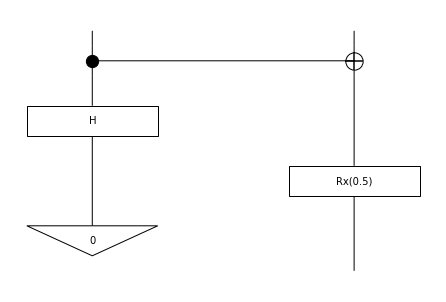

In [ ]:
from discopy.quantum.gates import CX, Rx, H, Bra, Id

equality_comparator = (CX >> (H @ Rx(0.5)) >> (Bra(0) @ Id(1)))
equality_comparator.draw()

In [ ]:
from lambeq import AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz
from lambeq import TketModel, NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset
import time
import json

SEED = 0
EPOCHS = 1000
BATCH_SIZE = 30

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE


def run_experiment(nlayers=1, seed=SEED):
    print(f'RUNNING WITH {nlayers} layers')
    ansatz = Sim15Ansatz({N: 1, S: 1, P:1}, n_layers=nlayers, n_single_qubit_params=3)

    train_circs = [ansatz(d) >> equality_comparator for d in train_X]
    test_circs = [ansatz(d) >> equality_comparator for d in test_X]

    lmbq_model = NumpyModel.from_diagrams(train_circs, use_jit=True)

    trainer = QuantumTrainer(
        lmbq_model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose = 'text',
        seed=seed
    )

    train_dataset = Dataset(
                train_circs,
                train_y,
                batch_size=BATCH_SIZE)

    np.random.seed(seed)

    train_embeddings, test_embeddings, max_w_param_length = generate_initial_parameterisation(train_circs, test_circs, embedding_model, lmbq_model)

    print('BEGINNING QNLP MODEL TRAINING')
    trainer.fit(train_dataset, logging_step=100)

    train_preds = lmbq_model.get_diagram_output(train_circs)
    train_loss = loss(train_preds, train_y)
    train_acc = acc(train_preds, train_y)
    print(f'TRAIN STATS: {train_loss, train_acc}')

    print('BEGINNING DNN MODEL TRAINING')
    NN_model = generate_OOV_parameterising_model(lmbq_model, train_embeddings, max_w_param_length)

    prediction_model = NumpyModel.from_diagrams(test_circs, use_jit=True)

    trained_wts = trained_params_from_model(lmbq_model, train_embeddings, max_w_param_length)

    print('Evaluating SMART MODEL')
    smart_loss, smart_acc = evaluate_test_set(prediction_model,
                                              test_circs,
                                              test_y,
                                              trained_wts,
                                              test_embeddings,
                                              max_w_param_length,
                                              OOV_strategy='model',
                                              OOV_model=NN_model)

    print('Evaluating EMBED model')
    embed_loss, embed_acc = evaluate_test_set(prediction_model,
                                              test_circs,
                                              test_y,
                                              trained_wts,
                                              test_embeddings,
                                              max_w_param_length,
                                              OOV_strategy='embed')

    print('Evaluating ZEROS model')
    zero_loss, zero_acc = evaluate_test_set(prediction_model,
                                              test_circs,
                                              test_y,
                                              trained_wts,
                                              test_embeddings,
                                              max_w_param_length,
                                              OOV_strategy='zeros')

    rand_losses = []
    rand_accs = []

    print('Evaluating RAND MODEL')
    for _ in range(1000):


        rl, ra = evaluate_test_set(prediction_model,
                                   test_circs,
                                   test_y,
                                   trained_wts,
                                   test_embeddings,
                                   max_w_param_length,
                                   OOV_strategy='random')

        rand_losses.append(rl)
        rand_accs.append(ra)

    res =  {'TRAIN': (train_loss, train_acc),
            'NN': (smart_loss, smart_acc),
            'EMBED': (embed_loss, embed_acc),
            'RAND': (rand_losses, rand_accs),
            'ZERO': (zero_loss, zero_acc)
           }
    print(f'ZERO: {res["ZERO"]}')
    print(f'EMBED: {res["EMBED"]}')
    print(f'NN: {res["NN"]}')

    return res


RUNNING WITH 3 layers
882 591 377
OOV word count: 291 / 377
OOV symbol count: 3183 / 4338
Max params/word: 54
BEGINNING QNLP MODEL TRAINING


Epoch 1:     train/loss: 0.9772   valid/loss: -----   train/acc: 0.5167   valid/acc: -----
Epoch 100:   train/loss: 0.7960   valid/loss: -----   train/acc: 0.6667   valid/acc: -----
Epoch 200:   train/loss: 0.7481   valid/loss: -----   train/acc: 0.6500   valid/acc: -----
Epoch 300:   train/loss: 0.6598   valid/loss: -----   train/acc: 0.7000   valid/acc: -----
Epoch 400:   train/loss: 0.7139   valid/loss: -----   train/acc: 0.5500   valid/acc: -----
Epoch 500:   train/loss: 0.6611   valid/loss: -----   train/acc: 0.6833   valid/acc: -----
Epoch 600:   train/loss: 0.6949   valid/loss: -----   train/acc: 0.6333   valid/acc: -----
Epoch 700:   train/loss: 0.6310   valid/loss: -----   train/acc: 0.6833   valid/acc: -----
Epoch 800:   train/loss: 0.5563   valid/loss: -----   train/acc: 0.7000   valid/acc: -----
Epoch 900:   train/loss: 0.5502   valid/loss: -----   train/acc: 0.6833   valid/acc: -----
Epoch 1000:  train/loss: 0.5934   valid/loss: -----   train/acc: 0.7500   valid/acc: -----

TRAIN STATS: (0.3374997998781813, DeviceArray(0.8833333, dtype=float32))
BEGINNING DNN MODEL TRAINING
[-0.01694969  0.07588653 -0.01615061  0.01447961  0.02373532]
[-0.03489554  0.01386689 -0.10999884 -0.013063   -0.1504512 ]


2023-03-22 16:17:19.668034: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-22 16:17:19.668086: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: duvel3
2023-03-22 16:17:19.668091: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: duvel3
2023-03-22 16:17:19.668252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2023-03-22 16:17:19.668276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2023-03-22 16:17:19.668280: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2023-03-22 16:17:19.669578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

OOV NN model final epoch loss: (0.026328174397349358, 0.03092249669134617)


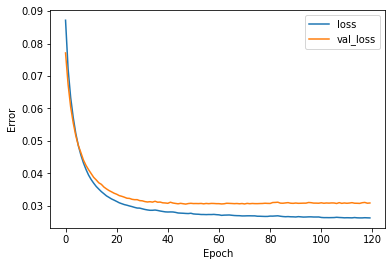

Evaluating SMART MODEL
Evaluating EMBED model
Evaluating ZEROS model
Evaluating RAND MODEL
ZERO: (3.2954275895712715, DeviceArray(0.5483871, dtype=float32))
EMBED: (0.896520908921957, DeviceArray(0.61290324, dtype=float32))
NN: (0.9454631694862919, DeviceArray(0.41935483, dtype=float32))
RUNNING WITH 2 layers
882 591 377
OOV word count: 291 / 377
OOV symbol count: 2223 / 3014
Max params/word: 36
BEGINNING QNLP MODEL TRAINING


Epoch 1:     train/loss: 0.8953   valid/loss: -----   train/acc: 0.5500   valid/acc: -----
Epoch 100:   train/loss: 0.7800   valid/loss: -----   train/acc: 0.5667   valid/acc: -----
Epoch 200:   train/loss: 0.6824   valid/loss: -----   train/acc: 0.6000   valid/acc: -----
Epoch 300:   train/loss: 0.7280   valid/loss: -----   train/acc: 0.5500   valid/acc: -----
Epoch 400:   train/loss: 0.5656   valid/loss: -----   train/acc: 0.6833   valid/acc: -----
Epoch 500:   train/loss: 0.5665   valid/loss: -----   train/acc: 0.6833   valid/acc: -----
Epoch 600:   train/loss: 0.5479   valid/loss: -----   train/acc: 0.6167   valid/acc: -----
Epoch 700:   train/loss: 0.4744   valid/loss: -----   train/acc: 0.8000   valid/acc: -----
Epoch 800:   train/loss: 0.4391   valid/loss: -----   train/acc: 0.7667   valid/acc: -----
Epoch 900:   train/loss: 0.3389   valid/loss: -----   train/acc: 0.8833   valid/acc: -----
Epoch 1000:  train/loss: 0.3672   valid/loss: -----   train/acc: 0.8500   valid/acc: -----

TRAIN STATS: (0.20197224754301715, DeviceArray(0.95, dtype=float32))
BEGINNING DNN MODEL TRAINING
[-0.01694969  0.07588653 -0.01615061  0.01447961  0.02373532]
[ 0.031975   -0.01256968 -0.16903348  0.16189781  0.07247581]
OOV NN model final epoch loss: (0.02625768631696701, 0.03256409615278244)


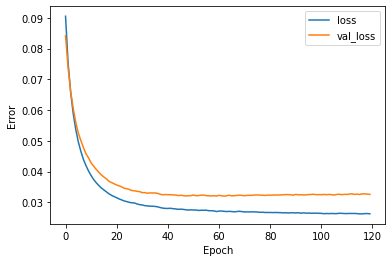

Evaluating SMART MODEL
Evaluating EMBED model
Evaluating ZEROS model
Evaluating RAND MODEL
ZERO: (3.4826200048424183, DeviceArray(0.58064514, dtype=float32))
EMBED: (0.9953541610870631, DeviceArray(0.61290324, dtype=float32))
NN: (0.9032434569521537, DeviceArray(0.58064514, dtype=float32))
RUNNING WITH 1 layers
882 591 377
OOV word count: 291 / 377
OOV symbol count: 1263 / 1690
Max params/word: 18
BEGINNING QNLP MODEL TRAINING


Epoch 1:     train/loss: 0.9926   valid/loss: -----   train/acc: 0.5333   valid/acc: -----
Epoch 100:   train/loss: 0.5931   valid/loss: -----   train/acc: 0.6667   valid/acc: -----
Epoch 200:   train/loss: 0.4345   valid/loss: -----   train/acc: 0.7500   valid/acc: -----
Epoch 300:   train/loss: 0.3772   valid/loss: -----   train/acc: 0.8500   valid/acc: -----


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
compr_results = {}

tf_seeds = [0, 1, 2]

for tf_seed in tf_seeds:
    tf.random.set_seed(tf_seed)
    this_seed_results = []
    for nl in [3,2,1]:
        this_seed_results.append(run_experiment(nl, tf_seed))
    compr_results[tf_seed] = this_seed_results

In [ ]:
import json

bkup = compr_results

with open('./results/MSR_OOV_S15.json', 'w') as f:
    json.dump(bkup, f)